# Mike's Sandbox, but clean(er)

## Imports

In [91]:
from astropy.io import fits
from astropy import table
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mechanize
from io import BytesIO
from astropy.table import Table
from astropy.io import ascii
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (0,0,0,1)
%matplotlib inline

Importing Melanie's catalog:

In [92]:
catFile = 'catalogs/clumpy_stripe82_fullsample.fits'
catFits = fits.open(catFile) 
catTable = table.Table(catFits[1].data)

## Spectra Generation

Spectra Plotter:

In [93]:
def specPlt(catTable,index,spData):
    plt.figure(figsize=(10,5))
    plt.plot(10**spData['loglam'],spData['flux'])
    plt.title('OBJ: %s, RA: %.3f, DEC: %.3f'%(index,catTable[index]['RA'],catTable[index]['DEC']))
    plt.xlabel("Wavelength [Angstroms]")
    plt.ylabel("Flux [$10^{-17}$ erg/cm$^2$/s/A]")
    plt.tight_layout()
    plt.savefig('spectra imgs/obj_%s.png'%index)
    plt.show()

Generating spectra from `astroquery`, using the RA/DEC:

In [94]:
def genSpectra(catTable,index,pltShow):
    pos = coords.SkyCoord(catTable[index]['RA'],
                          catTable[index]['DEC'],unit='deg')
    xid = SDSS.query_region(pos,spectro=True)
    
    if not xid:
        print('--------\nNo spectra for object %s\n--------'%index)
        return
    sp = SDSS.get_spectra(matches=xid)
    spData = sp[0][1].data
    if pltShow:
        specPlt(catTable,index,spData)
    return xid,table.Table(spData)

Here's an example from object 34:

/anaconda3/lib/python3.6/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


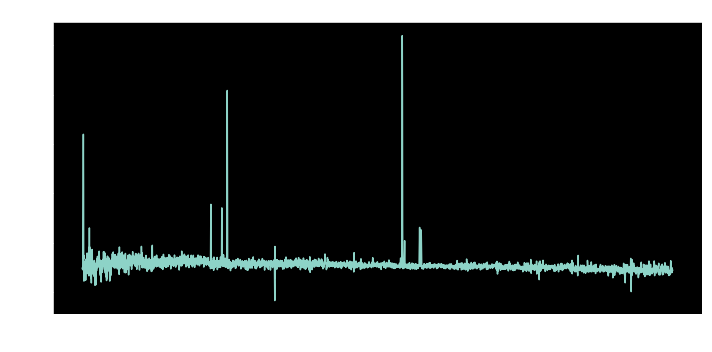

In [95]:
obj34 = genSpectra(catTable,34,True)

Here's an example with identified lines:

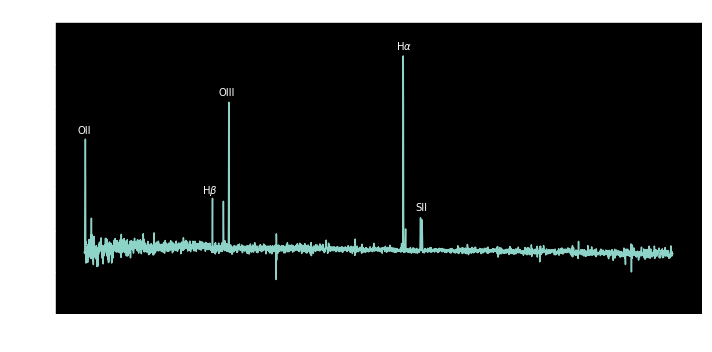

In [6]:
plt.figure(figsize=(10,5))
plt.plot(10**obj34[1]['loglam'],obj34[1]['flux'])
plt.title('OBJ: %s, RA: %.3f, DEC: %.3f, PLATE: %s, FIBER: %s'
          %(34,catTable[34]['RA'],catTable[34]['DEC'],obj34[0]['plate'][0],obj34[0]['fiberID'][0]))
plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux [$10^{-17}$ erg/cm$^2$/s/A]")
plt.ylim(-20,120)
# plt.xlim(6800,7000)
plt.text(6680,107,r'H$\alpha$')
plt.text(6850,30,'SII')
plt.text(5050,85,'OIII')
plt.text(4900,38,r'H$\beta$')
plt.text(3760,67,'OII')
plt.tight_layout()
plt.savefig('spectra imgs/label_obj_%s.png'%34)
plt.show()

## Generating Metallicities

Let's use the M91 calibration mentioned in [Kewley & Ellison 2008 (KE08)](http://adsabs.harvard.edu/abs/2008ApJ...681.1183K):

$$12 + \log(O/H)_\text{lower} = 12 - 4.944 + 0.767x + 0.602x^2 - y(0.29+0.332x - 0.331x^2)$$

$$12 + \log(O/H)_\text{upper} = 12 - 2.939 - 0.2x - 0.37x^2 - 0.305 x^3 - 0.0283x^4 - y(0.0047 - 0.221x - 0.102x^2 - 0.0817x^3 - 0.00717x^4)$$

where $$x = \log R_{23} = \log\left[\frac{[\text{OII}\lambda3727 + [\text{OIII}]\lambda4959 + [\text{OIII}]\lambda5007}{\text{H}\beta}\right]$$
and $$y = \log\text{O}_{32} = \log\left[\frac{[\text{OIII}]\lambda4959 + [\text{OIII}]\lambda5007}{[\text{OII}]\lambda3727}\right]$$

In [7]:
def getlogR23(OII3727,OIII4959,OIII5007,HB):
    return np.log10((OII3727 + OIII4959 + OIII5007)/HB)

def getlogO32(OIII4959,OIII5007,OII3727):
    return np.log10((OIII4959 + OIII5007)/OII3727)

def getlogOHlow(x,y):
    return (-4.944 + 0.767*x + 0.602*x**2 - y*(0.29 + 0.332*x - 0.331*x**2))

def getlogOHup(x,y):
    return (-2.939 - 0.2*x - 0.37*x**2 - 0.305*x**3 - 0.0283*x**4 - 
            y*(0.0047 - 0.221*x - 0.102*x**2 - 0.0817*x**3 - 0.00717*x**4))

### M91 Branches

We need to determine if we are using the upper branch or the lower branch. To do this, we need to get $$\log\left(\frac{[\text{NII}]\lambda6584}{[\text{OII}]\lambda3727}\right)$$

In [8]:
def getlogNiiOii(NII6584,OII3727):
    return np.log10(NII6584/OII3727)

If this value is greater than $-1.2$, then we use the upper branch, while if it is smaller, we use the lower branch.

In [9]:
def M91cal(obj):
    
    x = getlogR23(obj['OII3726'],obj['OIII4959'],obj['OIII5007'],obj['HBeta'])
    y = getlogO32(obj['OIII4959'],obj['OIII5007'],obj['OII3726'])
    
    branchCheck = getlogNiiOii(obj['NII6584'],obj['OII3726'])
    
    if branchCheck > -1.2:
        return branchCheck, getlogOHup(x,y)
    else:
        return branchCheck, getlogOHlow(x,y)
    

## Getting Data from SDSS

SQL Tutorial: http://skyserver.sdss.org/DR15/en/help/howto/search/searchhowtohome.aspx

Another link: http://balbuceosastropy.blogspot.com/2013/10/an-easy-way-to-make-sql-queries-from.html

In [10]:
def SDSS_select(sql):
    
    '''
    input: SQL query
    output: pandas DF
    '''
    
    url = 'http://skyserver.sdss.org/dr15/en/tools/search/sql.aspx'
    br = mechanize.Browser()
    br.open(url)
    br.select_form(name='sql')
    br['cmd'] = sql
    br['format'] = ['csv']
    response = br.submit()
    file_like = BytesIO(response.get_data())
    df = pd.read_csv(file_like,skiprows=1)
    return df

In [11]:
def getSpecData(catTable,index):
    pos = coords.SkyCoord(catTable[index]['RA'],catTable[index]['DEC'],unit='deg')
    xid = SDSS.query_region(pos,spectro = True)
    
    if not xid:
#         print('--------\nNo spectra for object %s\n--------'%index)
        return False, False
    
    sp = SDSS.get_spectra(matches=xid)
    spData = sp[0][1].data
    return xid, table.Table(spData)

In [12]:
def genSQLsearch(xid):
    SQL = "SELECT \
    s.specObjID, g.class, g.subClass, x.z, x.ra, x.dec, x.plate, x.fiberID, x.MJD, \
    s.oii_3726_flux as OII3726, s.oiii_4959_flux as OIII4959,s.oiii_5007_flux as OIII5007, \
    s.h_beta_flux as HBeta,s.h_alpha_flux as HAlpha,s.nii_6584_flux as NII6584,x.logMass as logM \
    FROM galSpecLine s \
    JOIN stellarMassFSPSGranEarlyDust x ON x.specObjID = s.specObjID \
    JOIN specObj g ON g.specObjID = s.specObjID \
    WHERE x.plate = %s AND x.fiberID = %s"%(xid['plate'][0],xid['fiberID'][0])
    return SQL

In [13]:
def getOneSDSS(catTable,index):
    xid, spectra = getSpecData(catTable,index)
    if not xid:
        return False
    SQLsearch = genSQLsearch(xid)
    SDSS = SDSS_select(SQLsearch)
    return SDSS

In [14]:
def getCatSDSS(catTable):
    from tqdm import tqdm_notebook as tqdm
    from astropy.table import Table
    
    objBar = tqdm(desc = 'Getting Obj',total = len(catTable))
    n = 0
    nospec = 0
    while n >= 0:
#         print(n)
        if type(getOneSDSS(catTable,n)) is bool:
            objBar.update(1)
            nospec += 1
            n+=1
        else:
            SDSSTable = getOneSDSS(catTable,n)
            objBar.update(1)
            break
            
    nrange = range(n+1,len(catTable))
    for obj in nrange:
#         print('\n',obj)
        objTable = getOneSDSS(catTable,obj)
#         print(objTable)
        if type(objTable) is bool:
            objBar.update(1)
            nospec += 1
            continue
        else:
            SDSSTable = SDSSTable.append(objTable,ignore_index=True)
            objBar.update(1)
            
    SDSSTable.to_csv('mikesandboximgs/catalog.csv',index=False)
    aTable = Table.from_pandas(SDSSTable)
#     aTable['Type_n'] = typeDic[aTable['type']]
    
    aTable.write('mikesandboximgs/catalog.ecsv', format='ascii.ecsv', serialize_method='data_mask')  
    
    print('Number of spectra:\t',len(catTable)-nospec)
    print('Number with no spectra:\t',nospec)
    return aTable
    

Let's get the whole catalog from SDSS:

In [15]:
# catSDSS = getCatSDSS(catTable)

Importing catalog:

In [16]:
catSDSS = Table.from_pandas(pd.read_csv('mikesandboximgs/catalog.csv',index_col = False))

In [88]:
# catSDSS.show_in_notebook()

## Generating BPT Diagram

[Kewley et al. 2013](https://arxiv.org/pdf/1307.0514.pdf) gives our classification line as:
$$ \log([\text{OIII}/\text{H}\alpha]) = \frac{0.61}{(\log([\text{NII}/\text{H}\alpha]) - 0.02} + 1.2$$
where we took $z \approx 0$ as we are in a low redshift regime. Above this line should be AGNs and other non-regular star forming galaxies (or possibly clumps?).

In [18]:
catSDSS['6584/6563'] = catSDSS['NII6584']/catSDSS['HAlpha']
catSDSS['5007/4861'] = catSDSS['OIII5007']/catSDSS['HBeta']

In [19]:
def logclassLine(x):
    return 0.61/(np.log10(x) - 0.02) + 1.2

In [70]:
def classSplit(cat):
    cat['subClass'].fill_value = '--'
    galCat = cat.filled()[cat.filled()['subClass'] == '--']
    sbCat = cat[cat['subClass'] == 'STARBURST']
    sfCat = cat[cat['subClass'] == 'STARFORMING']
    blCat = cat[cat['subClass'] == 'BROADLINE']
    agnCat = cat[cat['subClass'] == 'AGN BROADLINE']
    return galCat, sbCat, sfCat, blCat, agnCat

In [71]:
splitCat = classSplit(catSDSS)
galCat = splitCat[0]
sbCat = splitCat[1]
sfCat = splitCat[2]
blCat = splitCat[3]
agnCat = splitCat[4]

In [63]:
np.ma.is_masked(catSDSS[1]['subClass'])

True

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


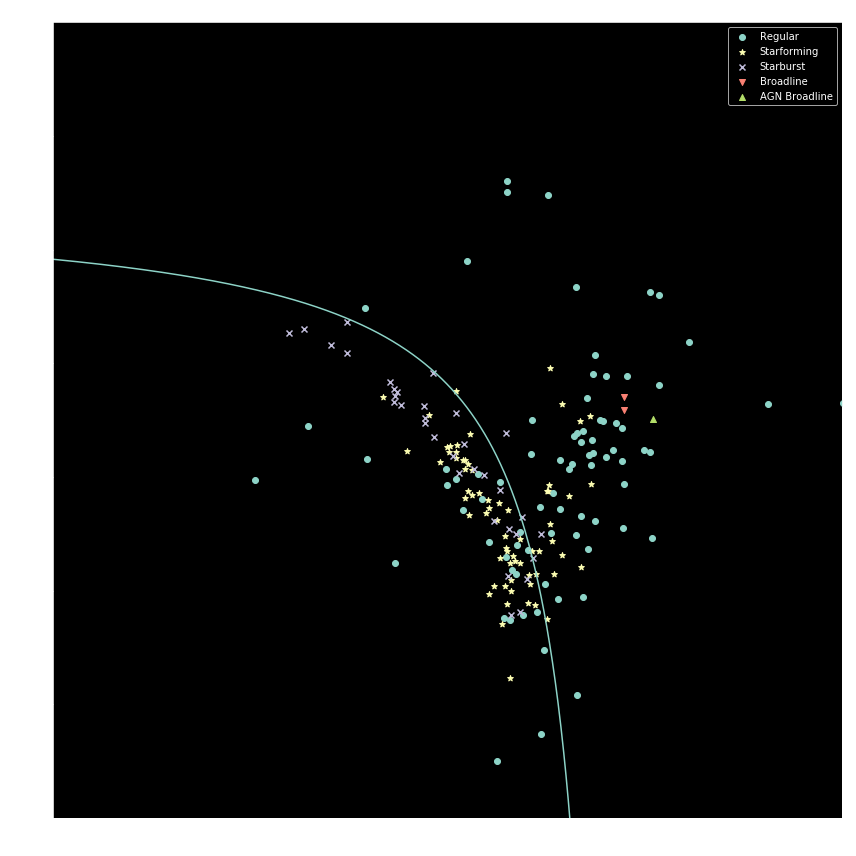

In [72]:
plt.figure(figsize=(12,12))
# plt.scatter(np.log10(catSDSS['6584/6563']),np.log10(catSDSS['5007/4861']),marker='.')
plt.scatter(np.log10(galCat['6584/6563']),np.log10(galCat['5007/4861']),marker='o',label='Regular')
plt.scatter(np.log10(sfCat['6584/6563']),np.log10(sfCat['5007/4861']),marker='*',label='Starforming')
plt.scatter(np.log10(sbCat['6584/6563']),np.log10(sbCat['5007/4861']),marker='x',label='Starburst')
plt.scatter(np.log10(blCat['6584/6563']),np.log10(blCat['5007/4861']),marker='v',label='Broadline')
plt.scatter(np.log10(agnCat['6584/6563']),np.log10(agnCat['5007/4861']),marker='^',c='C6',label='AGN Broadline')

niihaspace = np.logspace(-2.5,0,1000)
plt.plot(np.log10(niihaspace),logclassLine(niihaspace))

plt.title('BPT Diagram')
plt.xlabel('log 6584/6563')
plt.ylabel('log 5007/4861')
plt.xlim(-2.5,1)
plt.ylim(-1.5,2)
plt.legend()
plt.tight_layout()
plt.savefig('mikesandboximgs/BPTDiagram.png')
plt.show()

Okay, so this is telling us that even the ones that SDSS classify as "galaxies" are popping way above the SF line.

## M91 Calibration

### BPT Cut
The next test we want to make is by classifying them based on this line, and seeing what happens to the M91 calibration chart of $\log[O/H] + 12$:

In [73]:
catSDSS2 = catSDSS[(np.log10(catSDSS['5007/4861']) < logclassLine(catSDSS['6584/6563'])) 
                 & (np.log10(catSDSS['6584/6563']) < 0)
                 & (catSDSS['OII3726'] > 0)
                 & (catSDSS['NII6584'] > 0)
                 & (catSDSS['OIII4959'] > 0)]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [74]:
splitCat2 = classSplit(catSDSS2)
galCat2 = splitCat2[0]
sbCat2 = splitCat2[1]
sfCat2 = splitCat2[2]
blCat2 = splitCat2[3]
agnCat2 = splitCat2[4]

In [75]:
print("Below SF Line:\t",len(catSDSS2),"\nFraction Left:\t",len(catSDSS2)/len(catSDSS))

Below SF Line:	 75 
Fraction Left:	 0.3605769230769231


Quickly confirming:

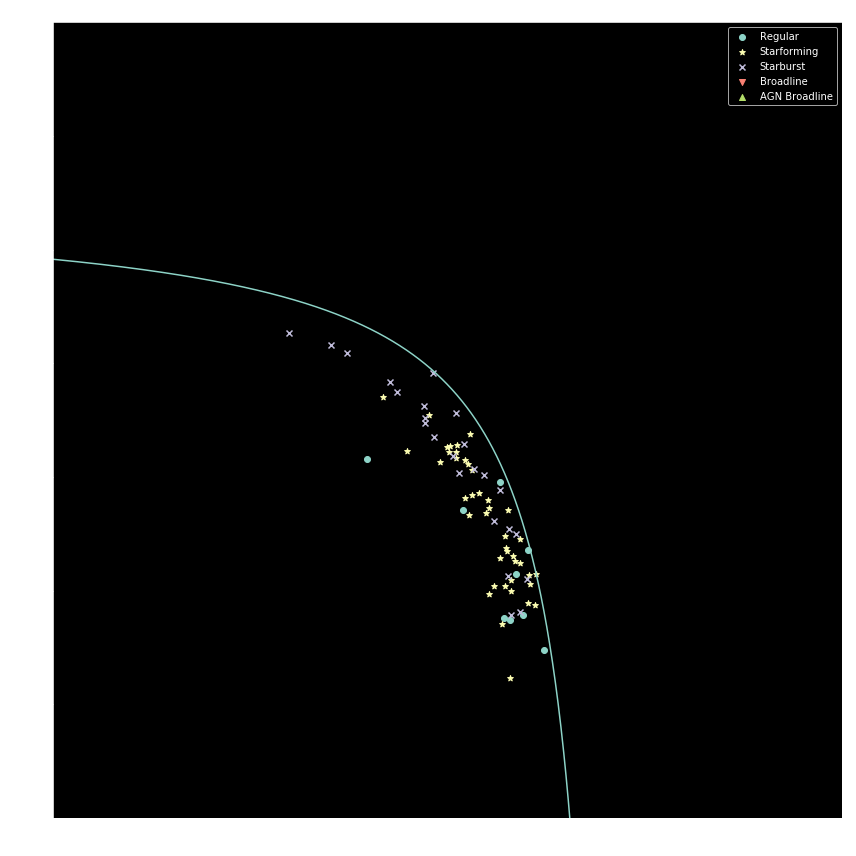

In [76]:
plt.figure(figsize=(12,12))
catSDSS2markerList = markerMap(catSDSS2['subClass'])
# plt.scatter(np.log10(galCat2['6584/6563']),np.log10(galCat2['5007/4861']),marker='.')
plt.scatter(np.log10(galCat2['6584/6563']),np.log10(galCat2['5007/4861']),marker='o',label='Regular')
plt.scatter(np.log10(sfCat2['6584/6563']),np.log10(sfCat2['5007/4861']),marker='*',label='Starforming')
plt.scatter(np.log10(sbCat2['6584/6563']),np.log10(sbCat2['5007/4861']),marker='x',label='Starburst')
plt.scatter(np.log10(blCat2['6584/6563']),np.log10(blCat2['5007/4861']),marker='v',label='Broadline')
plt.scatter(np.log10(agnCat2['6584/6563']),np.log10(agnCat2['5007/4861']),marker='^',c='C6',label='AGN Broadline')

niihaspace = np.logspace(-2.5,0,1000)
plt.plot(np.log10(niihaspace),logclassLine(niihaspace))

plt.title('BPT Diagram')
plt.xlabel('log 6584/6563')
plt.ylabel('log 5007/4861')
plt.xlim(-2.5,1)
plt.ylim(-1.5,2)
plt.legend()
plt.tight_layout()
plt.savefig('mikesandboximgs/BPTDiagram2.png')
plt.show()

### Generating Plot

In [77]:
M91list = [M91cal(gal)[1] + 12 for gal in catSDSS2]
logNiiOiiList = [M91cal(gal)[0] for gal in catSDSS2]
catSDSS2['M91'] = M91list
catSDSS2['logNiiOii'] = logNiiOiiList
lowBranch = catSDSS2[catSDSS2['logNiiOii'] < -1.2]
upBranch = catSDSS2[catSDSS2['logNiiOii'] >= -1.2]

In [78]:
len(lowBranch)

0

In [79]:
splitCat2 = classSplit(catSDSS2)
galCat2 = splitCat2[0]
sbCat2 = splitCat2[1]
sfCat2 = splitCat2[2]
blCat2 = splitCat2[3]
agnCat2 = splitCat2[4]

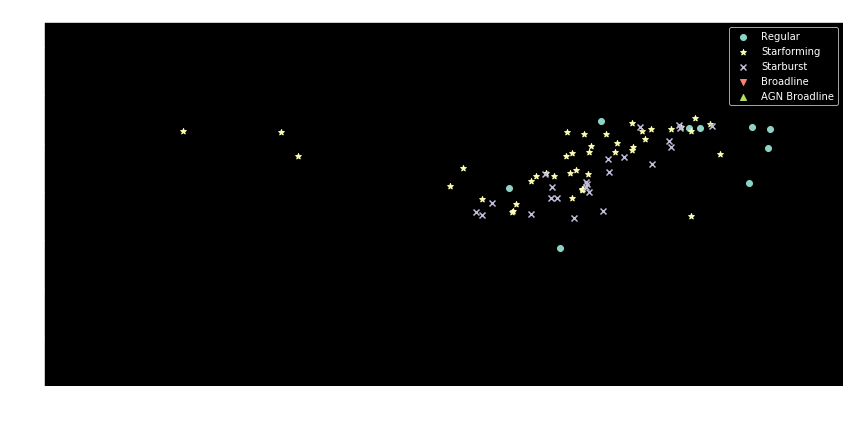

In [85]:
plt.figure(figsize=(12,6))
# plt.scatter(upBranch['logM'],upBranch['M91'],marker = '.',label='upper branch')
# plt.scatter(lowBranch['logM'],lowBranch['M91'],marker = '.',label='lower branch')
plt.scatter(galCat2['logM'],galCat2['M91'],marker = 'o',label='Regular')
plt.scatter(sfCat2['logM'],sfCat2['M91'],marker = '*',label='Starforming')
plt.scatter(sbCat2['logM'],sbCat2['M91'],marker = 'x',label='Starburst')
plt.scatter(blCat2['logM'],blCat2['M91'],marker = 'v',label='Broadline')
plt.scatter(agnCat2['logM'],agnCat2['M91'],marker = '^',c='C6',label='AGN Broadline')

plt.title('M91 Calibration')
plt.xlabel('log M')
plt.ylabel('log (O/H) + 12')
plt.xlim(6,12)
plt.ylim(8,9.5)
plt.legend()
plt.tight_layout()
plt.savefig('mikesandboximgs/m91.png')

### Investigating Lower Mass Objects

The three that are smaller mass are classified as `STARFORMING`. I will have to look into the images of the three specifically. The $\log[\text{O}/\text{H}] + 12$ measurements seem to line up reasonably with the other galaxies.

In [86]:
lowMass = catSDSS2[catSDSS2['logM'] <= 8.5]

In [87]:
lowMass

specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,6584/6563,5007/4861,M91,logNiiOii
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1661840406855313408,GALAXY,STARFORMING,0.07734468,334.1681200000001,-0.96763,1476,44,52964,26.13164,8.050787,29.79185,56.06377,301.7276,112.9446,7.77690722851942,0.3743263791578894,0.5313921985624585,9.04959965379015,0.6356988051339924
1678727256727382016,GALAXY,STARFORMING,0.03292816,4.879452,-0.60177,1491,38,52996,55.34501,9.218669,32.70643,48.17247,156.0314,34.77625,7.90438092122952,0.2228798177802673,0.6789444261421513,8.947588816527292,-0.20179572099619789
1702402778246178816,GALAXY,STARFORMING,0.02889183,44.169167,-0.248029,1512,153,53742,12.63868,3.245201,6.9761690000000005,20.96936,77.33118,22.20755,7.0448300934655,0.28717459115456406,0.3326839254989184,9.05262118532194,0.24479893054989146


Here is the first object `1661840406855313408`:

![](http://skyserver.sdss.org/dr15/SkyServerWS/ImgCutout/getjpeg?ra=334.16812&dec=-0.96763&scale=0.0845070422535211&width=600&height=600&opt=SIG)